In [74]:
import dataclasses
import datetime

import numpy as np

from csas_csv_parser import *
from matplotlib import pyplot as plt
import pandas as pd


## Parse the events from csas_logs.csv .

In [75]:
# csv_file_path = 'ui_logs_2023-03-20 16_29_49.774183.csv'
# csv_file_path = 'ui_logs_2023-04-06 13_50_36.138784.csv'
csv_file_path = 'ui_logs_2023-04-17 07_43_59.160150.csv'
graphs_folder = 'graphs 2023-04-17'
events = filter_events_by_time(
    events=parse_all_events_from_csv(csv_file_path),
    date_from=date(2023, 3, 6)
)

### Handle toggling

In [76]:
# Time locality of session can be in current setup handled by checking 'client_id' which is limited to 1 hour, so no time window has to be used for session/query sentiment.

@dataclasses.dataclass
class Client:
    id: uuid.UUID
    liked_incident_result: dict[str, list[list[int, Event]]] = dataclasses.field(default_factory=dict)
    disliked_incident_result: dict[str, list[list[int, Event]]] = dataclasses.field(default_factory=dict)


clients: dict[uuid.UUID, Client] = {}
for index, event in enumerate(events):
    client: Client = clients.get(event.client_id, Client(event.client_id))

    if event.event_type == EventType.LIKE:
        if event.similar_ticket_id not in client.liked_incident_result:
            client.liked_incident_result[event.similar_ticket_id] = []
        client.liked_incident_result[event.similar_ticket_id].append([index, event])

    if event.event_type == EventType.DISLIKE:
        if event.similar_ticket_id not in client.disliked_incident_result:
            client.disliked_incident_result[event.similar_ticket_id] = []
        client.disliked_incident_result[event.similar_ticket_id].append(([index, event]))

    clients[event.client_id] = client


def did_toggle(toggled_events: list[Event]) -> bool:
    if len(toggled_events) == 0:
        return False
    return len(toggled_events) % 2 == 0


event_indices_to_remove: list[int] = []

for client in clients.values():

    for result_id, possibly_toggled_events in client.liked_incident_result.items():
        if did_toggle(possibly_toggled_events):
            print(f"{client.id} : {result_id}  toggled {len(possibly_toggled_events)} likes")
            for index, event in possibly_toggled_events:
                event_indices_to_remove.append(index)

    for possibly_toggled_events in client.disliked_incident_result.values():
        if did_toggle(possibly_toggled_events):
            print(f"{client.id} : {result_id}  toggled {len(possibly_toggled_events)} dislikes.")
            for index, event in possibly_toggled_events:
                event_indices_to_remove.append(index)

untoggled_events = []
for index, event in enumerate(events):
    if index in event_indices_to_remove:
        continue
    untoggled_events.append(event)


d5211235-287c-4d4f-b298-452e6c0dd73a : INC50065207  toggled 2 likes
d5211235-287c-4d4f-b298-452e6c0dd73a : INC50065207  toggled 2 dislikes.
134298f2-7dde-485e-b123-e52231b6d8c6 : INC39707630  toggled 2 dislikes.
53fddac5-cca0-484c-b550-524c88620ded : INC44867361  toggled 2 dislikes.
3e58bdf5-096b-4121-8264-90d92db568bd : INC34248501  toggled 2 dislikes.
b947cbfb-7505-40bc-aa85-5d4e4b5efcbe : INC50402951  toggled 2 likes
4d7d0905-c90b-4f8b-8e34-ebbc061c26cd : INC50402951  toggled 2 likes
4d7d0905-c90b-4f8b-8e34-ebbc061c26cd : INC50404008  toggled 2 likes
22348b63-057f-4b5f-81bf-32424c5d07f2 : INC49242234  toggled 2 dislikes.
22348b63-057f-4b5f-81bf-32424c5d07f2 : INC49242234  toggled 2 dislikes.
22348b63-057f-4b5f-81bf-32424c5d07f2 : INC49242234  toggled 2 dislikes.
22348b63-057f-4b5f-81bf-32424c5d07f2 : INC49242234  toggled 2 dislikes.
6bd559b2-3c47-4030-b22b-e35c9c8f23db : INC48035878  toggled 2 dislikes.
45b842ad-0344-42e2-a479-b8b4980cf8ff : INC48325035  toggled 2 dislikes.
22677964

In [77]:
# events = untoggled_events
df: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in events])

## Normalized queries sentiment during time.

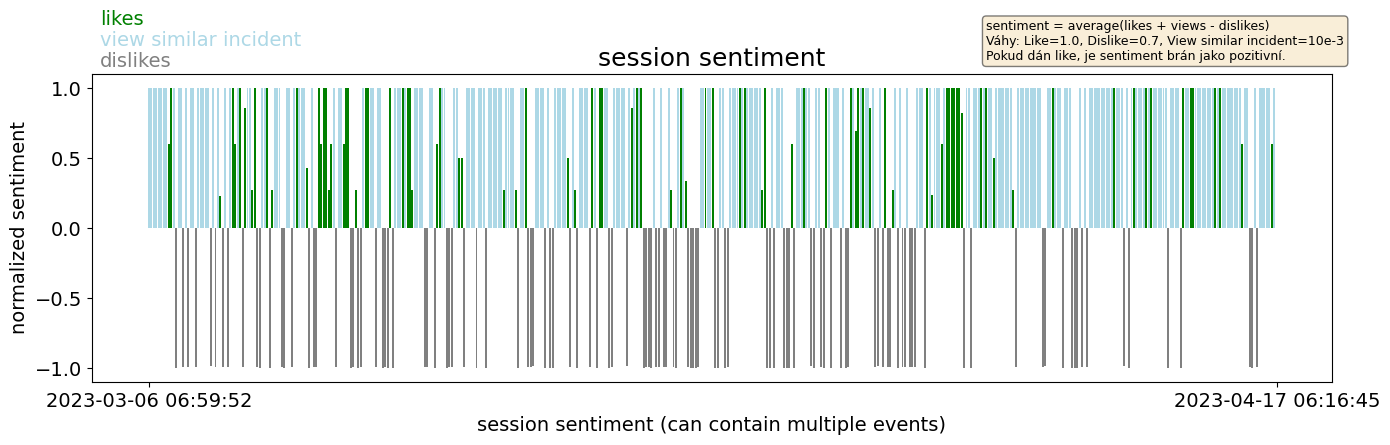

In [78]:
grouped_source_and_user = df.groupby(['source_ticket_id', 'client_id'])

#TODO: rename event_group to session
event_groups_sentiment: dict[str, np.ndarray] = {}
for source_and_user, indices in grouped_source_and_user.indices.items():
    contains_sentiment: bool = False
    for index in indices:
        event: Event = events[index]
        if event.event_type in [EventType.LIKE, EventType.DISLIKE]:
            contains_sentiment = True
            break
    if contains_sentiment:
        event_groups_sentiment[source_and_user] = indices

event_groups_view_similar: dict[str, np.ndarray] = {}
for source_and_user, indices in grouped_source_and_user.indices.items():
    contains_view_similar: bool = False
    for index in indices:
        event: Event = events[index]
        if event.event_type in [EventType.LIKE, EventType.DISLIKE]:
            contains_view_similar = False
            break
        if event.event_type == EventType.VIEW_SIMILAR_INCIDENT:
            contains_view_similar = True
    if contains_view_similar:
        event_groups_view_similar[source_and_user] = indices


@dataclasses.dataclass
class Session:
    timestamp_start: datetime = None
    sentiment: float = 0
    events: list[Event] = dataclasses.field(default_factory=list)
    only_view: bool = True


# non-discounted normalized sentiment: <-1, 1>, -1 strong dislike, +1 strong like
LIKE_WEIGHT = 1
DISLIKE_WEIGHT = 0.67
SIMILAR_VIEW_WEIGHT = 10e-4

# TODO: rename to sentiment_sessions
all_relevant_event_groups = event_groups_sentiment | event_groups_view_similar
sessions: dict[str, Session] = {name: Session() for name in all_relevant_event_groups.keys()}
for source_and_user, indices in all_relevant_event_groups.items():
    likes: float = 0
    dislikes: float = 0
    views: float = 0

    liked_ids: set[str] = set()
    disliked_ids: set[str] = set()
    similar_view_ids: set[str] = set()
    for index in indices:
        event: Event = events[index]
        match event.event_type:
            case EventType.LIKE:
                sessions[source_and_user].only_view = False
                if event.similar_ticket_id not in liked_ids:
                    likes += LIKE_WEIGHT
                    liked_ids.add(event.similar_ticket_id)
            case EventType.DISLIKE:
                sessions[source_and_user].only_view = False
                if event.similar_ticket_id not in disliked_ids:
                    dislikes += DISLIKE_WEIGHT
                    disliked_ids.add(event.similar_ticket_id)
            case EventType.VIEW_SIMILAR_INCIDENT:
                if event.similar_ticket_id not in similar_view_ids:
                    views += SIMILAR_VIEW_WEIGHT
                    similar_view_ids.add(event.similar_ticket_id)
    dislike_sum = dislikes
    if likes > 0 and dislikes > 0:
        dislikes = 0
    sessions[source_and_user].sentiment = float((likes + views - dislikes) / (likes + views + dislike_sum))

    sessions[source_and_user].events += [events[index] for index in indices]
    sessions[source_and_user].timestamp_start = events[indices[0]].timestamp

# Sort by timestamp
sessions_sorted_by_time = sorted(sessions.items(), key=lambda item: item[1].timestamp_start)

f, ax = plt.subplots(figsize=(16, 4))
colors: list[str] = []
for name, path in sessions_sorted_by_time:
    if path.only_view:
        colors.append('lightblue')  # mediumspringblue, cornflowerblue
    elif path.sentiment >= 0:
        colors.append('green')
    elif path.sentiment < 0:
        colors.append('grey')

plt.bar(
    range(len(sessions_sorted_by_time)),
    [path[1].sentiment for path in sessions_sorted_by_time],
    color=colors
)

plt.title('session sentiment', size=18)
plt.xlabel('session sentiment (can contain multiple events)')
plt.xticks([0, len(sessions_sorted_by_time)],
           [sessions_sorted_by_time[0][1].timestamp_start, sessions_sorted_by_time[-1][1].timestamp_start])
plt.ylabel('normalized sentiment')
plt.text(-20, 1.45, f'likes', color='green')
plt.text(-20, 1.3, f'view similar incident', color='lightblue')  #mediumseagreen
plt.text(-20, 1.15, f'dislikes', color='gray')

plt.text(340, 1.2, f"sentiment = average(likes + views - dislikes)\n"
                   f"Váhy: Like={LIKE_WEIGHT:0.1f}, Dislike={DISLIKE_WEIGHT:0.1f}, View similar incident=10e-3\n"
                   f"Pokud dán like, je sentiment brán jako pozitivní.",
         size=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig(f"{graphs_folder}/session_sentiment.png", bbox_inches='tight')

## Discounted (more interpretable) sentiment expressed by one user during one query session

Text(0.5, 1.0, 'session sentiments counts')

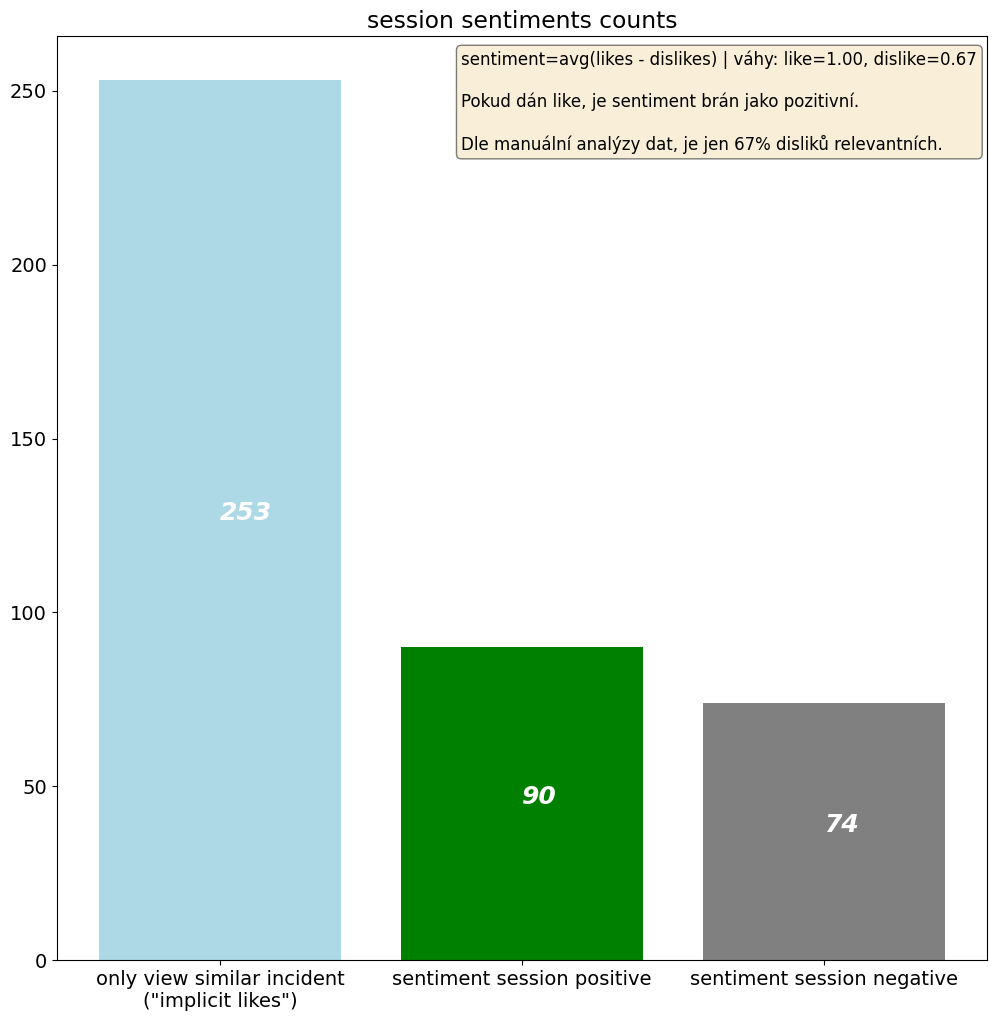

In [79]:
views_count = len([1 for path in sessions.values() if path.only_view])
likes_count = len([1 for path in sessions.values() if not path.only_view and path.sentiment > 0])
dislike_count = len([1 for path in sessions.values() if not path.only_view and path.sentiment < 0])

DISLIKE_MULTIPLE_CLICKS_BUG_CORRECTION = 4 + 1
dislike_count -= DISLIKE_MULTIPLE_CLICKS_BUG_CORRECTION

session_without_sentiment_count = len([event for event in events
                                       if event.event_type not in [EventType.LIKE, EventType.DISLIKE,
                                                                   EventType.VIEW_SIMILAR_INCIDENT]])
session_without_sentiment_count = 10
f, ax = plt.subplots(figsize=(12, 12))
import math

undecided_count = math.ceil(dislike_count - dislike_count * 0.675)
dislike_count = int(dislike_count * 0.675)
plt.bar(
    ['only view similar incident\n("implicit likes")', 'sentiment session positive', 'sentiment session negative', ],
    # 'not relevant'],
    [views_count, likes_count, dislike_count],  #, undecided_count],
    color=['lightblue', 'green', 'grey']  # , 'peru'
)
plt.rcParams.update({'font.size': 14})

plt.text(0, views_count / 2, f"{views_count}", size=18, weight='bold', style='oblique', color='white')
plt.text(1, likes_count / 2, f"{likes_count}", size=18, weight='bold', style='oblique', color='white')
plt.text(2, dislike_count / 2, f"{dislike_count}", size=18, weight='bold', style='oblique', color='white')
# plt.text(3, undecided_count / 2, f"{undecided_count}", size=18, weight='bold', style='oblique', color='white')
plt.text(0.8, views_count - 20, f"sentiment=avg(likes - dislikes) | "
                                f"váhy: like={LIKE_WEIGHT:.2f}, dislike={DISLIKE_WEIGHT:.2f}\n\n"
                                f"Pokud dán like, je sentiment brán jako pozitivní.\n\n"
                                f"Dle manuální analýzy dat, je jen {DISLIKE_WEIGHT * 100:0.0f}% disliků relevantních.",
         size=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.title('session sentiments counts')



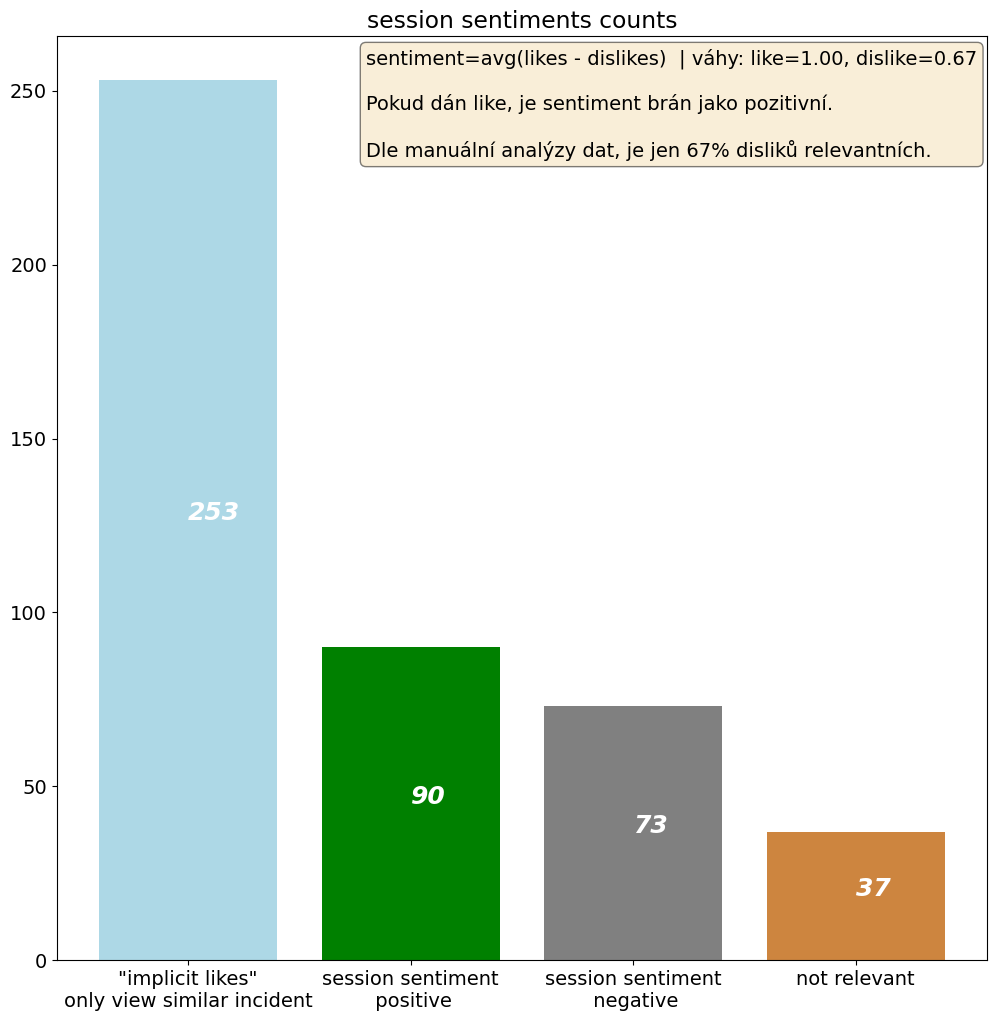

In [80]:
views_count = len([1 for path in sessions.values() if path.only_view])
likes_count = len([1 for path in sessions.values() if not path.only_view and path.sentiment > 0])
dislike_count = len([1 for path in sessions.values() if not path.only_view and path.sentiment < 0])

DISLIKE_MULTIPLE_CLICKS_BUG_CORRECTION = 4 + 1
dislike_count -= DISLIKE_MULTIPLE_CLICKS_BUG_CORRECTION

session_without_sentiment_count = len([event for event in events
                                       if event.event_type not in [EventType.LIKE, EventType.DISLIKE,
                                                                   EventType.VIEW_SIMILAR_INCIDENT]])
session_without_sentiment_count = 10
f, ax = plt.subplots(figsize=(12, 12))
import math

undecided_count = math.ceil(dislike_count - dislike_count * DISLIKE_WEIGHT)
dislike_count = int(dislike_count * DISLIKE_WEIGHT)
plt.bar(
    ['"implicit likes"\nonly view similar incident', 'session sentiment\n positive', 'session sentiment\n negative',
     'not relevant'],
    [views_count, likes_count, dislike_count, undecided_count],
    color=['lightblue', 'green', 'grey', 'peru']  #
)
plt.rcParams.update({'font.size': 14})

plt.text(0, views_count / 2, f"{views_count}", size=18, weight='bold', style='oblique', color='white')
plt.text(1, likes_count / 2, f"{likes_count}", size=18, weight='bold', style='oblique', color='white')
plt.text(2, dislike_count / 2, f"{dislike_count}", size=18, weight='bold', style='oblique', color='white')
plt.text(3, undecided_count / 2, f"{undecided_count}", size=18, weight='bold', style='oblique', color='white')
plt.text(0.80, views_count - 22, f"sentiment=avg(likes - dislikes)  | "
                                 f"váhy: like={LIKE_WEIGHT:.2f}, dislike={DISLIKE_WEIGHT:.2f}\n\n"
                                 f"Pokud dán like, je sentiment brán jako pozitivní.\n\n"
                                 f"Dle manuální analýzy dat, je jen {DISLIKE_WEIGHT * 100:0.0f}% disliků relevantních.",
         size=14, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.title('session sentiments counts')
plt.savefig(f"{graphs_folder}/session_sentiment_counts.png", bbox_inches='tight')

## Sentiment by assignment groups

{''}


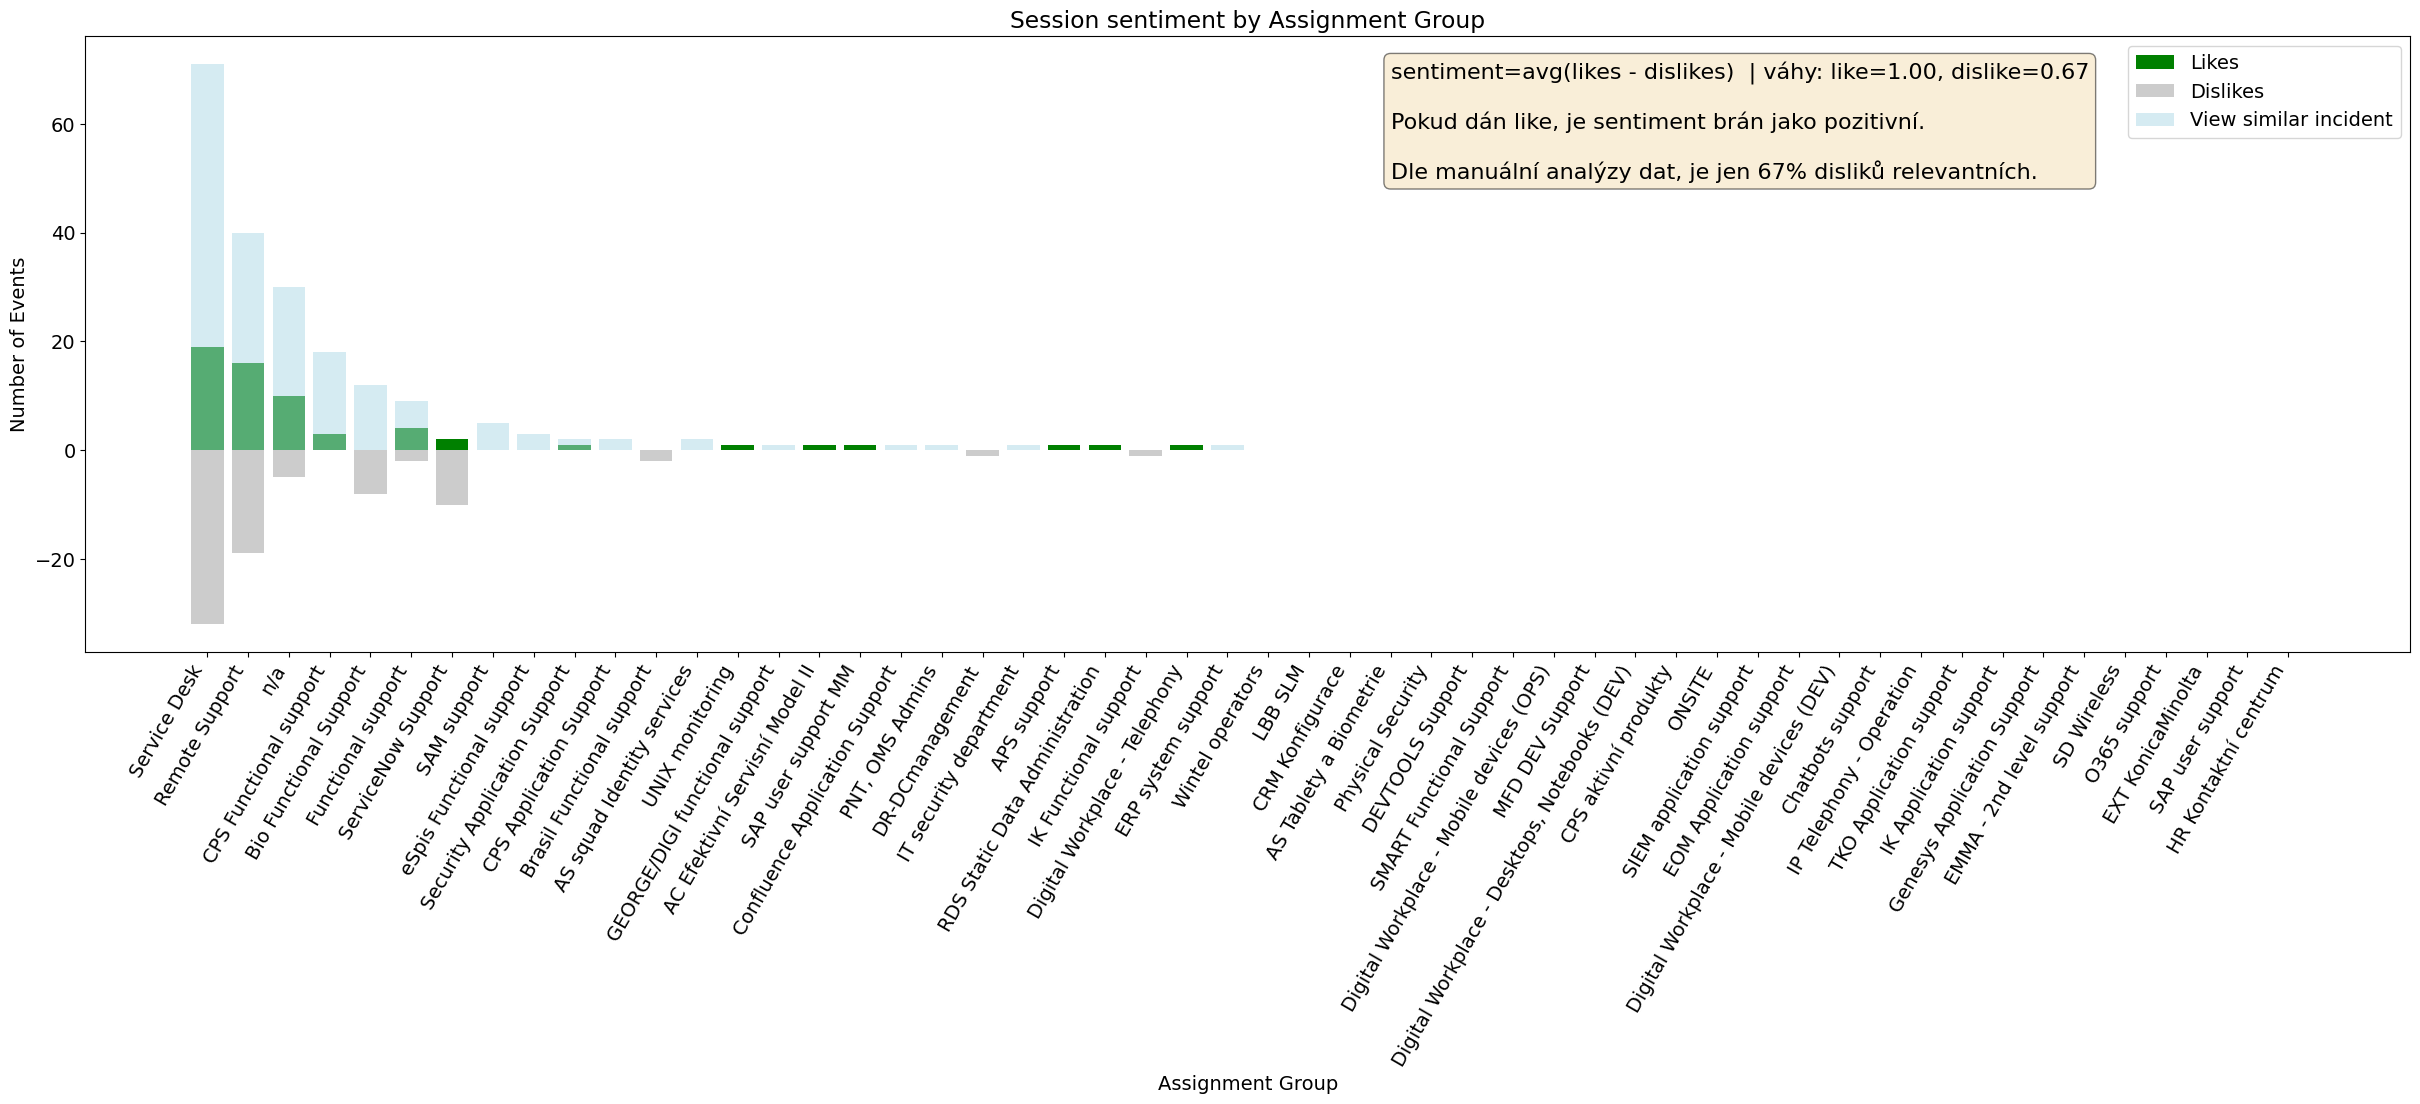

In [81]:
@dataclasses.dataclass
class Sentiment:
    likes: int
    dislikes: int
    view_similar_incident: int


unique_assignment_groups = df['assignment_group'].unique()
unique_assignment_groups = unique_assignment_groups[1:]

# double check correctness of retrieved groups
x: set[str] = get_unique_assignment_groups(csv_file_path)
print(x.difference(set(unique_assignment_groups)))

sentiment_assignment_groups: dict[str, Sentiment] = {assignment_group: Sentiment(0, 0, 0)
                                                     for assignment_group in unique_assignment_groups}
path: Session
for path in sessions.values():
    ag = path.events[0].assignment_group
    if ag == '':
        continue
    if path.only_view:
        sentiment_assignment_groups[ag].view_similar_incident += 1
    elif path.sentiment >= 0:
        sentiment_assignment_groups[ag].likes += 1
    elif path.sentiment < 0:
        sentiment_assignment_groups[ag].dislikes += 1
    else:
        print("ERR")
#
# sentiment_assignment_groups_sorted_by_likes = sorted(sentiment_assignment_groups.items(),
#                                                      key=lambda x: x[1].likes, reverse=True)
# sorted_indices = [i[0] for i in
#                   sorted(enumerate(sentiment_assignment_groups.items()), key=lambda x: x[1], reverse=True)]

# TODO sort by the most active
# create lists to hold the likes and dislikes values for each assignment group
# likes_values = [group[1].likes for group in sentiment_assignment_groups_sorted_by_likes]
# dislikes_values = [- group[1].dislikes for group in sentiment_assignment_groups_sorted_by_likes]
# view_similar_incident_values = [group[1].view_similar_incident for group in sentiment_assignment_groups_sorted_by_likes]
total_sentiment = [sentiment_assignment_groups[group_name].likes +
                   sentiment_assignment_groups[group_name].dislikes +
                   sentiment_assignment_groups[group_name].view_similar_incident
                   for group_name in unique_assignment_groups]
sorted_indices = [i[0] for i in sorted(enumerate(total_sentiment), key=lambda x: x[1], reverse=True)]
unique_assignment_groups = [unique_assignment_groups[i] for i in sorted_indices]

likes_values = [sentiment_assignment_groups[group_name].likes for group_name in unique_assignment_groups]
dislikes_values = [-1 * sentiment_assignment_groups[group_name].dislikes for group_name in unique_assignment_groups]
view_similar_incident_values = [sentiment_assignment_groups[group_name].view_similar_incident for group_name in
                                unique_assignment_groups]

# set up the bar plot
f, ax = plt.subplots(figsize=(30, 8))
index = range(len(sentiment_assignment_groups))

# plot the likes and dislikes bars side-by-side for each assignment group
rects1 = ax.bar(index, likes_values, color='g', label='Likes')
rects2 = ax.bar(index, dislikes_values, color='grey', alpha=0.4, label='Dislikes')
rects3 = ax.bar(index, view_similar_incident_values, alpha=0.5, color='lightblue', label='View similar incident')

# add labels and title to the plot
ax.set_xlabel('Assignment Group')
ax.set_ylabel('Number of Events')
ax.set_title('Session sentiment by Assignment Group')
ax.set_xticks(index)
# ax.set_xticklabels(unique_assignment_groups, rotation='35')
# plt.xticks(ticks=list(range(len(unique_assignment_groups))),
#            labels=[unique_assignment_groups[i] for i in sorted_indices], rotation=60, ha='right')
plt.xticks(ticks=list(range(len(unique_assignment_groups))),
           labels=unique_assignment_groups, rotation=60, ha='right')

plt.text(29, 50, f"sentiment=avg(likes - dislikes)  | "
                 f"váhy: like={LIKE_WEIGHT:.2f}, dislike={DISLIKE_WEIGHT:.2f}\n\n"
                 f"Pokud dán like, je sentiment brán jako pozitivní.\n\n"
                 f"Dle manuální analýzy dat, je jen {DISLIKE_WEIGHT * 100:0.0f}% disliků relevantních.",
         size=16, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.legend()
# display the plot
plt.savefig(f"{graphs_folder}/session_sentiment_assignment_groups.png", bbox_inches='tight')

# Last week trend statistics

In [82]:
newer_sessions: dict[tuple[str], Session] = {}
older_sessions: dict[tuple[str], Session] = {}

session: Session
key: tuple[str]
for key, session in sessions_sorted_by_time:
    if session.only_view:
        continue

    is_newer = True if session.timestamp_start.date() >= date(year=2023, month=4, day=10) else False
    if is_newer:
        newer_sessions[key] = session
    else:
        older_sessions[key] = session

like_count_older = len([1 for session in older_sessions.values() if session.sentiment >= 0])
like_percentage_older = like_count_older / len(older_sessions) * 100
dislike_percentage_older = (len(older_sessions) - like_count_older) / len(older_sessions) * 100

like_count_newer = len([1 for session in newer_sessions.values() if session.sentiment >= 0])
like_percentage_newer = like_count_newer / len(newer_sessions) * 100
dislike_percentage_newer = (len(newer_sessions) - like_count_newer) / len(newer_sessions) * 100


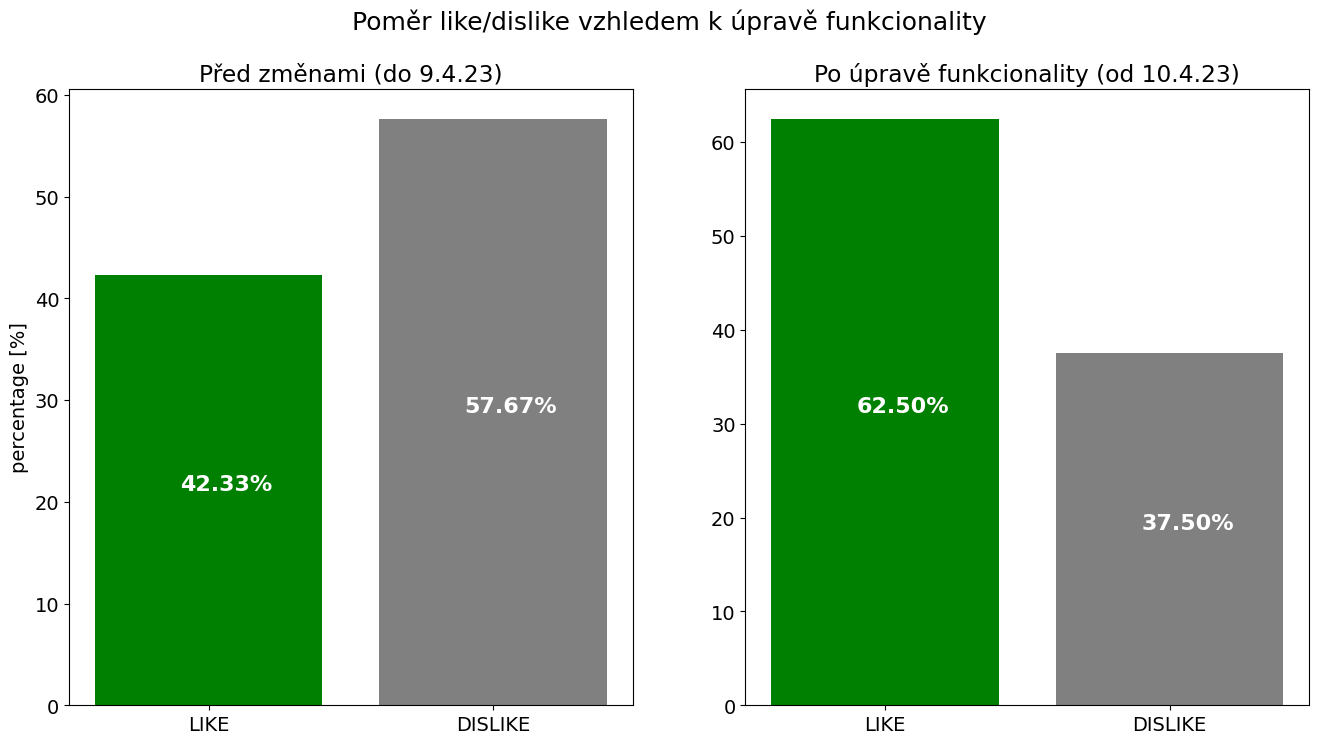

In [83]:
import matplotlib.patheffects as pe

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

ax1.bar(['LIKE', 'DISLIKE'], [like_percentage_older, dislike_percentage_older], color=['green', 'gray'])
ax1.set_ylabel("percentage [%]")
ax1.text(0 - 0.1, like_percentage_older / 2, f"{like_percentage_older:.2f}%", fontweight='bold', color='white', size=16)
ax1.text(1 - 0.1, dislike_percentage_older / 2, f"{dislike_percentage_older:.2f}%", fontweight='bold', color='white',
         size=16)
ax1.set_title("Před změnami (do 9.4.23)")
ax2.bar(['LIKE', 'DISLIKE'], [like_percentage_newer, dislike_percentage_newer], color=['green', 'gray'])
ax2.text(0 - 0.1, like_percentage_newer / 2, f"{like_percentage_newer:.2f}%", fontweight='bold', color='white', size=16)
ax2.text(1 - 0.1, dislike_percentage_newer / 2, f"{dislike_percentage_newer:.2f}%", fontweight='bold', color='white',
         size=16)
ax2.set_title("Po úpravě funkcionality (od 10.4.23)")
fig.suptitle("Poměr like/dislike vzhledem k úpravě funkcionality", fontsize=18)

plt.savefig(f"{graphs_folder}/new_functionality_improvement.png", bbox_inches='tight')

## (raw!) Event counts

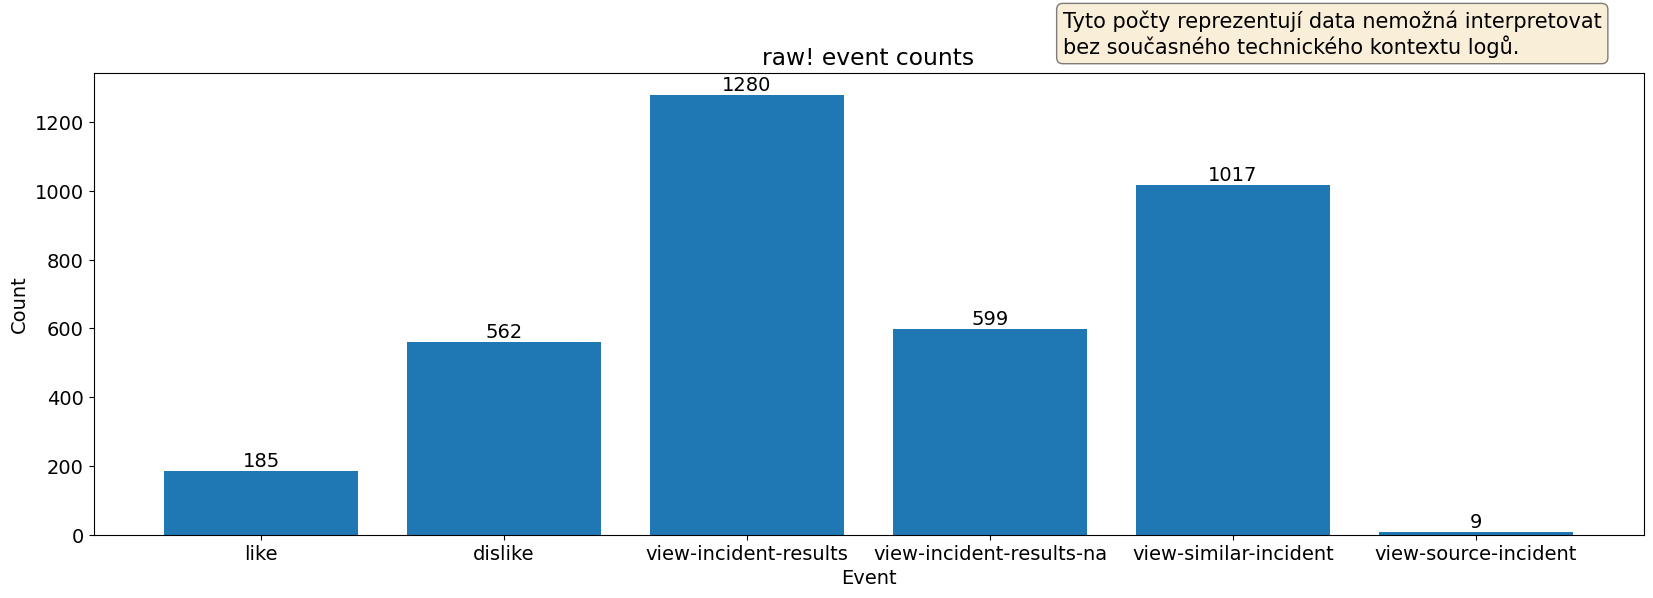

In [84]:
event_counts: dict[EventType, int] = get_event_type_counts(events)

f, ax = plt.subplots(figsize=(20, 6))
plt.bar(
    x=range(len(event_counts)),
    height=event_counts.values(),
    tick_label=[event_type.value for event_type in event_counts.keys()]
)
plt.title('raw! event counts')
plt.xlabel('Event')
plt.ylabel('Count')

plt.text(3.3, 1400, f"Tyto počty reprezentují data nemožná interpretovat\nbez současného technického kontextu logů.",
         size=15, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# add the count above each bar
for i, count in enumerate(event_counts.values()):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom')

plt.savefig(f"{graphs_folder}/raw_event_counts.png", bbox_inches='tight')

## (!raw) Counts by dislikes

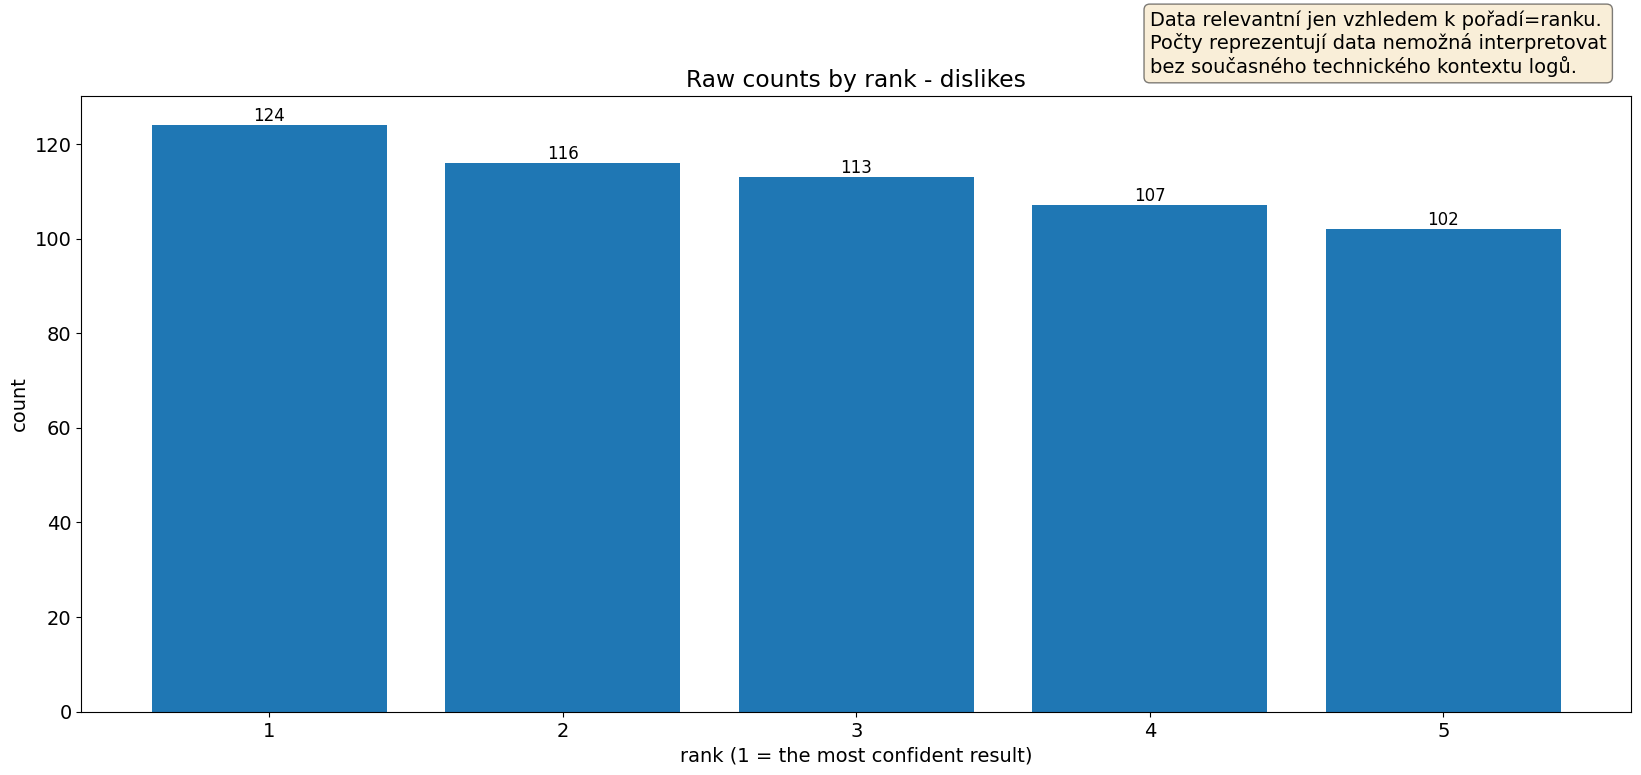

In [85]:
dislike_events: list[Event] = [event for event in events if event.event_type == EventType.DISLIKE]

rank_count_dislikes: dict[int, int] = {i: 0 for i in range(5)}
dislike_event: Event
for dislike_event in dislike_events:
    rank_count_dislikes[dislike_event.rank] += 1

f, ax = plt.subplots(figsize=(20, 8))
plt.bar(
    x=range(len(rank_count_dislikes)),
    height=rank_count_dislikes.values(),
    tick_label=list(range(1, 6))
)
plt.title('Raw counts by rank - dislikes')
plt.xlabel('rank (1 = the most confident result)')
plt.ylabel('count')
plt.text(3, 135, f"Data relevantní jen vzhledem k pořadí=ranku.\n"
                 f"Počty reprezentují data nemožná interpretovat\nbez současného technického kontextu logů.",
         size=14, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# add the count above each bar
for i, count in enumerate(rank_count_dislikes.values()):
    ax.text(i, count + 0.1, str(count), size=12, ha='center', va='bottom')

plt.savefig(f"{graphs_folder}/raw_dislikes_by_rank.png", bbox_inches='tight')

## (!raw) Counts by likes

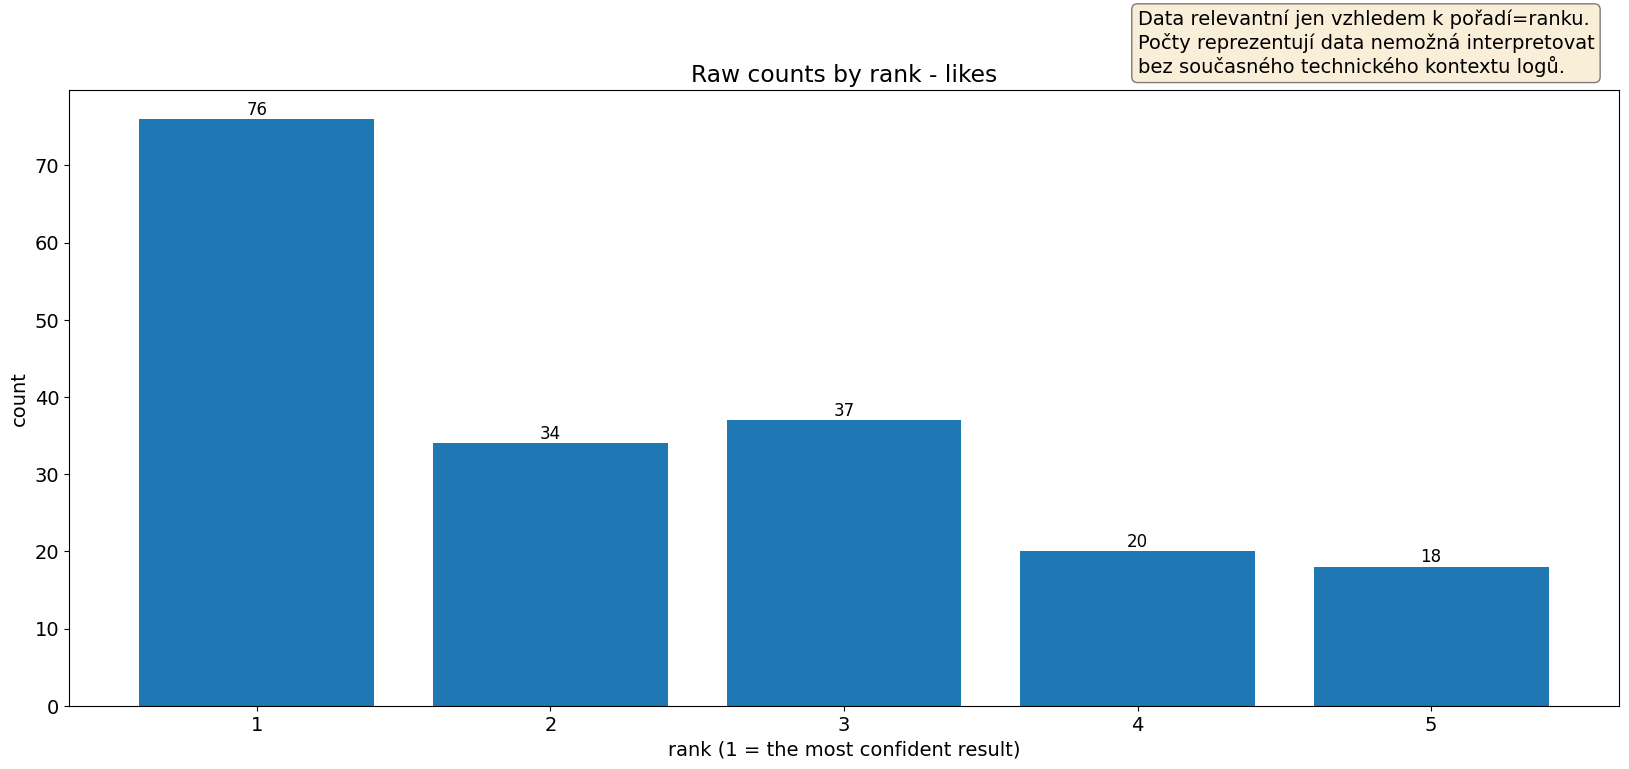

In [86]:
like_events: list[Event] = [event for event in events if event.event_type == EventType.LIKE]

rank_count_likes: dict[int, int] = {i: 0 for i in range(5)}
like_event: Event
for like_event in like_events:
    rank_count_likes[like_event.rank] += 1

f, ax = plt.subplots(figsize=(20, 8))
plt.bar(
    range(len(rank_count_likes)),
    rank_count_likes.values(),
    tick_label=list(range(1, 6))
)
plt.title('Raw counts by rank - likes')
plt.xlabel('rank (1 = the most confident result)')
plt.ylabel('count')
plt.text(3, 82, f"Data relevantní jen vzhledem k pořadí=ranku.\n"
                f"Počty reprezentují data nemožná interpretovat\nbez současného technického kontextu logů.",
         size=14, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
# add the count above each bar
for i, count in enumerate(rank_count_likes.values()):
    ax.text(i, count + 0.1, str(count), size=12, ha='center', va='bottom')

plt.savefig(f"{graphs_folder}/raw_likes_by_rank.png", bbox_inches='tight')

# User uniqueness statistics

In [87]:
df: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in events])

unique_users: pd.Series = df['client_id'].unique()

print(f"unique users {unique_users.size} from total of {len(events)} events")
print(f"uniqueness: {float(unique_users.size / len(events)) * 100:.2f}% ")

unique users 674 from total of 3652 events
uniqueness: 18.46% 


In [88]:
df_likes = pd.DataFrame.from_records([event.to_dict() for event in events
                                      if event.event_type == EventType.LIKE])

unique_likers = df_likes['client_id'].unique()

print(f"unique users {unique_likers.size} liked from total of {len(like_events)} like events")
print(f"like uniqueness: {float(unique_likers.size / df_likes.shape[0]) * 100:.2f}%")

unique users 80 liked from total of 185 like events
like uniqueness: 43.24%


In [89]:
df_dislikes: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in dislike_events
                                                       if event.event_type == EventType.DISLIKE])

unique_dislikers = df_dislikes['client_id'].unique()

print(f"unique users {unique_dislikers.size} disliked from total of {df_dislikes.shape[0]} dislike events")
print(f"dislike uniqueness: {float(unique_dislikers.size / df_dislikes.shape[0]) * 100:.2f}%")

unique users 121 disliked from total of 562 dislike events
dislike uniqueness: 21.53%


In [90]:
unique_dislikers_with_counts: pd.Series = df_dislikes['client_id'].value_counts()
OUTLIER_THRESHOLD: float = 0.05
k = int(unique_dislikers_with_counts.size * OUTLIER_THRESHOLD)
unique_dislikers_with_counts = unique_dislikers_with_counts[k:-k]

print(
    f"unique users {unique_dislikers_with_counts.size} disliked from total of {df_dislikes.shape[0] - 2 * k} dislike events, best {k} and worst {k} outliers removed ")
print(f"dislike uniqueness: {float(unique_dislikers_with_counts.size / df_dislikes.shape[0]) * 100:.2f}%")

unique users 109 disliked from total of 550 dislike events, best 6 and worst 6 outliers removed 
dislike uniqueness: 19.40%


### Remove togle events to see better raw likes/dislikes trends = plateau on 5 for dislikes, and on 1 for likes

In [91]:
events = untoggled_events
df: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in events])
df_dislikes: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in dislike_events
                                                       if event.event_type == EventType.DISLIKE])
df_likes: pd.DataFrame = pd.DataFrame.from_records([event.to_dict() for event in dislike_events
                                                    if event.event_type == EventType.LIKE])

## Dislikes by unique client ids

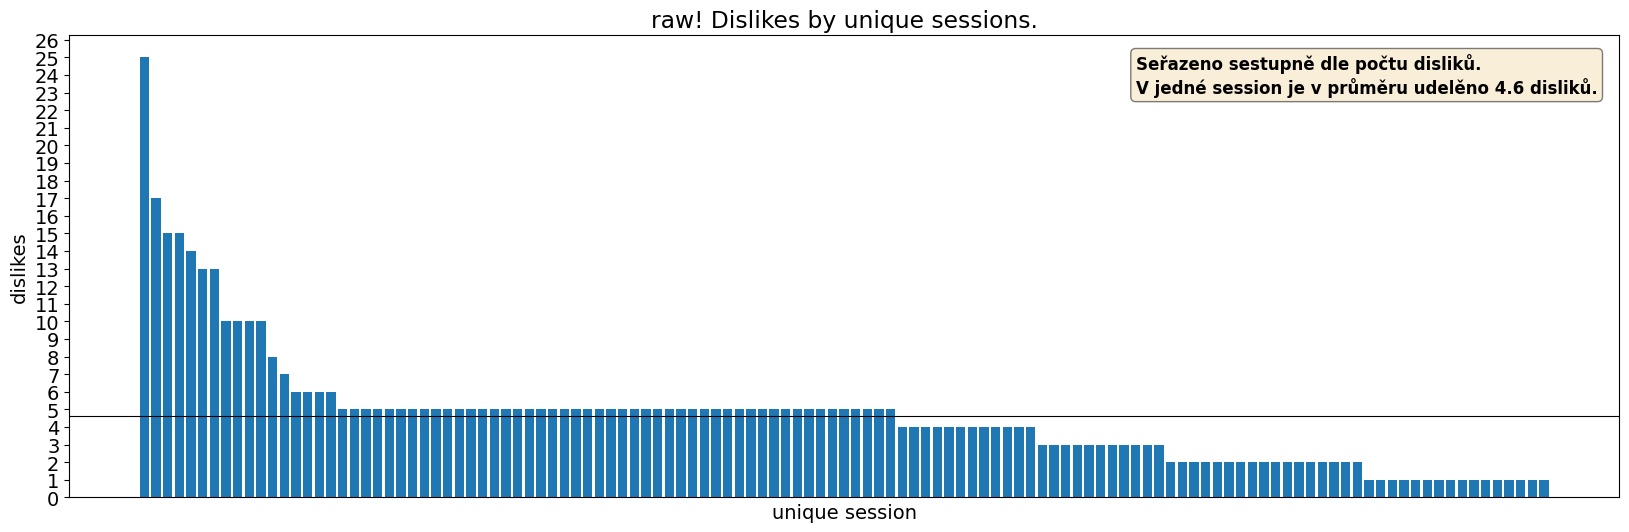

In [92]:
unique_dislikers_with_counts: pd.Series = df_dislikes['client_id'].value_counts()

f, ax = plt.subplots(figsize=(20, 6))
# plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(range(0, 100))
plt.title("raw! Dislikes by unique sessions.")
plt.xlabel("unique session")
plt.ylabel('dislikes')
plt.xticks([], [])
plt.bar(
    range(unique_dislikers_with_counts.size),
    unique_dislikers_with_counts
)
plt.text(85, 23,
         f"Seřazeno sestupně dle počtu disliků.\n"
         f"V jedné session je v průměru udelěno {unique_dislikers_with_counts.mean():.1f} disliků.",
         color='k', weight='bold',
         size=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
         )
plt.axhline(unique_dislikers_with_counts.mean(), linewidth=.8, color='k')

plt.savefig(f"{graphs_folder}/raw_dislikes_by_unique_session.png", bbox_inches='tight')

## Dislikes by unique client ids, removing the top k outliers.

In [93]:
# unique_dislikers_with_counts: pd.Series = df_dislikes['client_id'].value_counts()
# OUTLIER_THRESHOLD: float = 0.05
# k = int(unique_dislikers_with_counts.size * OUTLIER_THRESHOLD)
# unique_dislikers_with_counts = unique_dislikers_with_counts[k:-k]
#
# f, ax = plt.subplots(figsize=(14, 6))
# # plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.yticks(range(0, 15))
# plt.title(f"Dislikes by unique clients (removed {k} best and {k} worst outliers)")
# plt.xlabel("unique clients (id)")
# plt.ylabel('dislikes')
# plt.bar(range(unique_dislikers_with_counts.size), unique_dislikers_with_counts)
# plt.text(36, 8.5,
#          f"Sorted by: user with most dislikes (descending) \n"
#          f"(removed best {k} and worst {k})\n\n"
#          f"mean={unique_dislikers_with_counts.mean():.2f} dislikes per user",
#          color='k', )
# plt.axhline(unique_dislikers_with_counts.mean(), linewidth=.6, color='k')

## Likes by unique client ids.

In [94]:
unique_likers_with_counts: pd.Series = df_likes['client_id'].value_counts()

f, ax = plt.subplots(figsize=(20, 6))
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks(range(0, 100))
plt.xticks([], [])

plt.bar(
    range(unique_likers_with_counts.size),
    unique_likers_with_counts
)
plt.title("raw! Likes by unique session")
plt.xlabel("unique session")
plt.ylabel('likes')

plt.text(53, 7.5,
         f"Seřazeno sestupně dle počtu liků.\n"
         f"V jedné session je v průměru udelěno {unique_likers_with_counts.mean():.1f} liků.",
         color='k', weight='bold',
         size=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
         )
plt.axhline(float(unique_likers_with_counts.mean()), linewidth=.8, color='k')

plt.savefig(f"{graphs_folder}/raw_likes_by_unique_session.png", bbox_inches='tight')


KeyError: 'client_id'

dislike

## List all source ticket ids with counts of dislikes that in total generated and their respective results.

In [ ]:
# dataclasses.dataclass(slots=True):
# class
# TODO: add timestamp info

@dataclasses.dataclass(slots=True)
class SourceTicketDislikeInfo:
    results: set[tuple] = dataclasses.field(default_factory=set)
    unique_users: set[str] = dataclasses.field(default_factory=set)


source_ticket_dislikes: dict[str, int] = df_dislikes.source_ticket_id.value_counts().to_dict()
source_ticket_dislike_info: dict[str, SourceTicketDislikeInfo] = {source_id: SourceTicketDislikeInfo()
                                                                  for source_id in source_ticket_dislikes.keys()}
for source_ticket, indices in df.groupby('source_ticket_id').groups.items():
    if not source_ticket in source_ticket_dislikes:
        continue
    for index in indices:
        p = tuple(df.similar_tickets_ids[index])
        source_ticket_dislike_info[source_ticket].results.add(p)
        source_ticket_dislike_info[source_ticket].unique_users.add(df.client_id[index])

with open('dislike_logs.txt', 'w') as f:
    for source_id, dislikes in source_ticket_dislikes.items():
        info: SourceTicketDislikeInfo = source_ticket_dislike_info[source_id]
        f.write(f"{source_id}   dislikes:{dislikes}   users:{len(info.unique_users)}:\n")
        for results in info.results:
            if len(results[0]) == 0:
                continue
            f.write(f"  {results}\n")

# TODO: More statistics

In [ ]:
print(df_dislikes.source_ticket_id.value_counts())
f, ax = plt.subplots(figsize=(10, 6))
plt.bar(
    range(df_dislikes.source_ticket_id.value_counts().size),
    df_dislikes.source_ticket_id.value_counts()
)
plt.title('generated dislikes by unique source ticket')
plt.xlabel('unique ticket')
plt.ylabel('number of dislikes)')

In [ ]:
print(df_likes.source_ticket_id.value_counts())
f, ax = plt.subplots(figsize=(10, 6))
plt.bar(
    range(df_likes.source_ticket_id.value_counts().size),
    df_likes.source_ticket_id.value_counts()
)
plt.title('generated likes by unique source ticket')
plt.xlabel('unique ticket')
plt.ylabel('number of likes)')

Unique users for incident 'INC44915742

In [ ]:
pprint(
    set(
        [event.client_id for event in events
         if event.event_type == EventType.DISLIKE and event.source_ticket_id == 'INC50162183']  # INC44915742
    )
)

In [ ]:
df_INC50643483: pd.DataFrame = pd.DataFrame.from_records(
    [event.to_dict() for event in events
     if event.event_type == EventType.LIKE and event.source_ticket_id == 'INC50643483']
)
unique_users: pd.Series = df_INC50643483['client_id'].value_counts()

plt.bar(range(unique_users.size), unique_users, tick_label=['user' + str(i) for i in range(1, unique_users.size + 1)])

plot likes that changed to dislike


plot dislikes that changed to likes